In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## Pytorch

In [15]:
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO

class CocoDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path))

        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)

In [16]:
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

In [17]:
train_data_dir = r'C:\Users\malla.praveen\Desktop\MacCamish-NGIN\Repo\Database_Generation\ouput\Aadhar\POST_Labeling\COCO\train'
train_coco = r'C:\Users\malla.praveen\Desktop\MacCamish-NGIN\Repo\Database_Generation\ouput\Aadhar\POST_Labeling\COCO\train\_annotations.coco.json'

# create own Dataset
my_dataset = CocoDataset(root=train_data_dir,
                          annotation=train_coco,
                          transforms=get_transform()
                          )

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

# Batch size
train_batch_size = 5

# own DataLoader
data_loader = torch.utils.data.DataLoader(my_dataset,
                                          batch_size=train_batch_size,
                                          shuffle=True,
                                          num_workers=0,
                                          collate_fn=collate_fn)

loading annotations into memory...


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\malla.praveen\\Desktop\\MacCamish-NGIN\\Repo\\Database_Generation\\ouput\\Aadhar\\POST_Labeling\\COCO\\train\\_annotations.coco.json'

In [103]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# DataLoader is iterable over Dataset
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break

[{'boxes': tensor([[129.0000, 393.0000, 304.5000, 405.0000],
        [ 15.0000, 348.0000, 227.0000, 380.0000]]), 'labels': tensor([1, 1]), 'image_id': tensor([43]), 'area': tensor([2106., 6784.]), 'iscrowd': tensor([0, 0])}, {'boxes': tensor([[120.0000, 291.0000, 295.0000, 335.0000],
        [196.0000, 154.0000, 303.0000, 179.0000],
        [117.0000, 124.0000, 195.5000, 153.0000],
        [156.0000, 180.0000, 196.0000, 206.0000]]), 'labels': tensor([1, 1, 1, 1]), 'image_id': tensor([49]), 'area': tensor([7700.0000, 2675.0000, 2276.5000, 1040.0000]), 'iscrowd': tensor([0, 0, 0, 0])}, {'boxes': tensor([[ 71.0000, 115.0000, 303.0000, 145.0000],
        [125.0000, 386.0000, 297.5000, 398.0000],
        [158.0000, 344.0000, 206.0000, 352.0000],
        [195.0000, 338.0000, 309.5000, 346.0000],
        [117.0000, 333.0000, 201.5000, 338.5000]]), 'labels': tensor([1, 1, 1, 1, 1]), 'image_id': tensor([5]), 'area': tensor([6960.0000, 2070.0000,  384.0000,  916.0000,  464.7500]), 'iscrowd': ten

In [104]:
import matplotlib.pyplot as plt
import matplotlib
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

{'boxes': tensor([[117.0000, 288.0000, 296.0000, 333.5000],
        [167.0000, 180.0000, 212.5000, 207.5000],
        [197.0000, 154.0000, 300.5000, 178.0000],
        [118.0000, 126.0000, 211.0000, 154.5000]]), 'labels': tensor([1, 1, 1, 1]), 'image_id': tensor([51]), 'area': tensor([8144.5000, 1251.2500, 2484.0000, 2650.5000]), 'iscrowd': tensor([0, 0, 0, 0])}


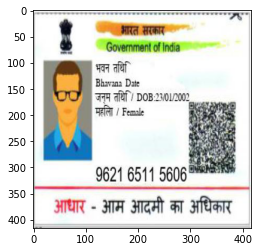

In [105]:
for images,labels in data_loader:
    print(labels[0])
    plt.imshow(images[0].permute(1,2,0))
    plt.show()
    break

In [106]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model
    

# 2 classes; Only target class or background
num_classes = 5
num_epochs = 5
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.05, momentum=0.9, weight_decay=0.005)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')

Iteration: 1/12, Loss: 2.5568630695343018
Iteration: 2/12, Loss: 1.710647463798523
Iteration: 3/12, Loss: 1.1820622682571411
Iteration: 4/12, Loss: 0.8298199772834778
Iteration: 5/12, Loss: 1.5174872875213623
Iteration: 6/12, Loss: 0.9071981906890869
Iteration: 7/12, Loss: 1.4547349214553833
Iteration: 8/12, Loss: 1.7685370445251465
Iteration: 9/12, Loss: 3.5230422019958496
Iteration: 10/12, Loss: 3.5214180946350098
Iteration: 11/12, Loss: 63640.28125
Iteration: 12/12, Loss: nan
Iteration: 1/12, Loss: nan
Iteration: 2/12, Loss: nan
Iteration: 3/12, Loss: nan
Iteration: 4/12, Loss: nan
Iteration: 5/12, Loss: nan
Iteration: 6/12, Loss: nan
Iteration: 7/12, Loss: nan
Iteration: 8/12, Loss: nan
Iteration: 9/12, Loss: nan
Iteration: 10/12, Loss: nan
Iteration: 11/12, Loss: nan
Iteration: 12/12, Loss: nan
Iteration: 1/12, Loss: nan
Iteration: 2/12, Loss: nan
Iteration: 3/12, Loss: nan
Iteration: 4/12, Loss: nan
Iteration: 5/12, Loss: nan
Iteration: 6/12, Loss: nan


KeyboardInterrupt: 

## Detectron2

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image

In [2]:
import pytesseract
import cv2
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [5]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog
from detectron2.data.datasets import register_coco_instances

In [4]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "../Database_Generation/ouput/Aadhar/POST_Labeling/COCO v2/train/_annotations.coco.json", "../Database_Generation/ouput/Aadhar/POST_Labeling/COCO v2/train")
register_coco_instances("my_dataset_val", {}, "../Database_Generation/ouput/Aadhar/POST_Labeling/COCO v2/valid/_annotations.coco.json", "../Database_Generation/ouput/Aadhar/POST_Labeling/COCO v2/valid")
register_coco_instances("my_dataset_test", {}, "../Database_Generation/ouput/Aadhar/POST_Labeling/COCO v2/test/_annotations.coco.json", "../Database_Generation/ouput/Aadhar/POST_Labeling/COCO v2/test")

WARNING [01/27 18:43:25 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/27 18:43:25 d2.data.datasets.coco]: Loaded 57 images in COCO format from ../Database_Generation/ouput/Aadhar/POST_Labeling/COCO v2/train/_annotations.coco.json


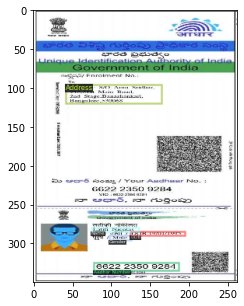

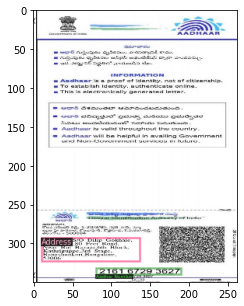

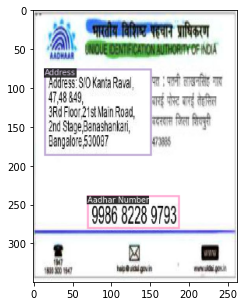

In [5]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(5,5))
    plt.imshow(vis.get_image()[:, :, ::-1])

In [6]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [29]:
#from .detectron2.tools.train_net import Trainer
#from detectron2.engine import DefaultTrainer
# select from modelzoo here: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines

from detectron2.config import get_cfg
#from detectron2.evaluation.coco_evaluation import COCOEvaluator
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001
cfg.MODEL.DEVICE = 'cpu'


cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05




cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6 #your number of classes + 1

cfg.TEST.EVAL_PERIOD = 500


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
#trainer.resume_or_load(resume=False)
#trainer.train()

[01/27 18:57:26 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

ValueError: Milestone must be smaller than total number of updates: num_updates=1500, milestone=1500

In [30]:
model_path = r'Repo\Database_Generation\ouput\Aadhar\Models\Detectron\v2\content\output'

In [31]:
#test evaluation
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(model_path, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
cfg.MODEL.DEVICE = 'cpu'
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std


WARNING [01/27 18:57:38 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [01/27 18:57:38 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/27 18:57:38 d2.data.datasets.coco]: Loaded 8 images in COCO format from ../Database_Generation/ouput/Aadhar/POST_Labeling/COCO v2/test/_annotations.coco.json
[01/27 18:57:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/27 18:57:38 d2.data.common]: Serializing 8 elements to byte tensors and concatenating them all ...
[01/27 18:57:38 d2.data.common]: Serialized dataset takes 0.00 MiB
[01/27 18:57:38 d2.evaluation.evaluator]: Start inference on 8 batches
[01/27 18:57:59 d2.evaluation.evaluator]: Inference done 1/8. Dataloading: 6.2739 s/iter. Inference: 14.9435 s

OrderedDict([('bbox',
              {'AP': 0.0,
               'AP50': 0.0,
               'AP75': 0.0,
               'APs': 0.0,
               'APm': 0.0,
               'APl': 0.0,
               'AP-Example': nan,
               'AP-Aadhar Number': 0.0,
               'AP-Address': 0.0,
               'AP-DOB': 0.0,
               'AP-Gender': 0.0,
               'AP-Name': 0.0})])

In [78]:
model_path = r'\Repo\Database_Generation\ouput\Aadhar\Models\Detectron\v3\content\output'

In [32]:
cfg.MODEL.WEIGHTS = os.path.join(model_path, "model_final.pth")
cfg.DATASETS.TEST = ("my_dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")

The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std


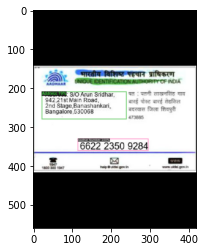

In [79]:
from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('../Database_Generation/ouput/Aadhar/POST_Labeling/COCO v3/test/*jpg'):
    im = cv2.imread(imageName)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=0.8
                 )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
    break

In [80]:
def crop_object(image, box):
    """Crops an object in an image

    Inputs:
    image: PIL image
    box: one box from Detectron2 pred_boxes
    """

    color_coverted = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pil_image=Image.fromarray(color_coverted)

    x_top_left = box[0]
    y_top_left = box[1]
    x_bottom_right = box[2]
    y_bottom_right = box[3]
    x_center = (x_top_left + x_bottom_right) / 2
    y_center = (y_top_left + y_bottom_right) / 2

    crop_img = pil_image.crop((int(x_top_left), int(y_top_left), int(x_bottom_right), int(y_bottom_right)))
    return crop_img

In [13]:
# ['Example','Aadhar Number','Address','DOB','Gender','Name']
# {0: 0,1: 1, 2: 2,3: 3,4: 4,5: 5}

In [35]:
dic = {0:'Example', 1: 'Aadhar Number', 2: 'Address', 3: 'DOB', 4: 'Gender', 5: 'Name'}

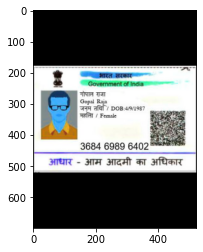

{'instances': Instances(num_instances=3, image_height=700, image_width=525, fields=[pred_boxes: Boxes(tensor([[147.3453, 418.1063, 373.9608, 451.7013],
         [216.8340, 332.1392, 270.4494, 349.3512],
         [247.2565, 306.1725, 362.4339, 327.3235]])), scores: tensor([0.9960, 0.9678, 0.8654]), pred_classes: tensor([1, 4, 3])])}

In [93]:
image = cv2.imread('../Database_Generation/ouput/Aadhar/POST_Labeling/COCO v3/test/Front_17_JPG.rf.72c385f72d37a59f4ad06d38ab4aa59f.jpg')
#image = cv2.imread(r'\Aadhar\Internet\Big Layout\56758c2f-7bda-4ad8-98ad-87ff0ad6e01c.jpg')
bigger = cv2.resize(image, (525, 700))
plt.imshow(image)
plt.show()
outputs = predictor(image)
outputs

Aadhar Number  :  


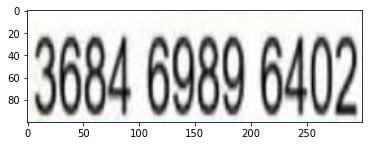

Gender  :  Female



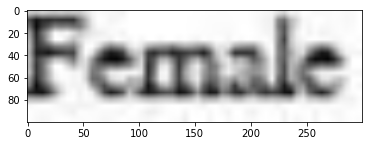

DOB  :  DOB:4/9/1987



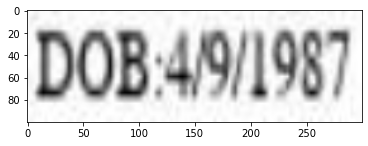

In [94]:
# Get pred_boxes from Detectron2 prediction outputs
boxes = list(outputs["instances"].pred_boxes)
pred_classes = list(outputs["instances"].pred_classes)

for i in range(len(boxes)):
    box = boxes[i].detach().cpu().numpy()
    crop_img = crop_object(image, box)
    crop_img = np.array(crop_img)
    crop_img = cv2.cvtColor(crop_img, cv2.COLOR_RGB2BGR)
    img = cv2.resize(crop_img, (300, 100))
    text = pytesseract.image_to_string(img)
    print(dic[pred_classes[i].item()], ' : ' , text)
    plt.imshow(img)
    plt.show()

In [25]:
img = cv2.imread(r'\Desktop\1.png')

#img = cv2.resize(img, (600, 360))
data = pytesseract.image_to_string(img, lang='eng', config='--psm 6')
print(data)

oO) ExsING 130841 06 a
Elen
4A) 42
IN) 449, #acrw



In [21]:
image = cv2.imread(r'\Desktop\1.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (3,3), 0)
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Morph open to remove noise and invert image
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
invert = 255 - opening

# Perform text extraction
data = pytesseract.image_to_string(image, lang='eng', config='--psm 6')
print(data)

cv2.waitKey()

-1

### To convert from PIL image to OpenCV use:

In [ ]:
import cv2
import numpy as np
from PIL import Image

pil_image=Image.open("demo2.jpg") # open image using PIL

# use numpy to convert the pil_image into a numpy array
numpy_image=numpy.array(pil_img)  

# convert to a openCV2 image, notice the COLOR_RGB2BGR which means that 
# the color is converted from RGB to BGR format
opencv_image=cv2.cvtColor(numpy_image, cv2.COLOR_RGB2BGR) 

### To convert from OpenCV image to PIL image use:

In [ ]:
import cv2
import numpy as np
from PIL import Image

opencv_image=cv2.imread("demo2.jpg") # open image using openCV2

# convert from openCV2 to PIL. Notice the COLOR_BGR2RGB which means that 
# the color is converted from BGR to RGB
color_coverted = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2RGB)
pil_image=Image.fromarray(color_coverted)

## Scalability

In [6]:
def register_coco(dataset_name, dataset_path):
    register_coco_instances(dataset_name + '_train', {}, dataset_path + "\\train\_annotations.coco.json", dataset_path + "\\train")
    register_coco_instances(dataset_name + '_val', {}, dataset_path + "\\valid\_annotations.coco.json", dataset_path + "\\valid")
    register_coco_instances(dataset_name + '_test', {}, dataset_path + "\\test\_annotations.coco.json", dataset_path + "\\test")

In [7]:
def get_config(dataset_name, model_path , inference = True):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
    cfg.DATASETS.TRAIN = (dataset_name + '_train',)
    cfg.DATASETS.TEST = (dataset_name + '_val',)

    cfg.DATALOADER.NUM_WORKERS = 4
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
    cfg.SOLVER.IMS_PER_BATCH = 4
    cfg.SOLVER.BASE_LR = 0.001
    cfg.MODEL.DEVICE = 'cpu'

    cfg.SOLVER.WARMUP_ITERS = 1000
    cfg.SOLVER.MAX_ITER = 2 #1500 #adjust up if val mAP is still rising, adjust down if overfit
    cfg.SOLVER.STEPS = (1000, 1500)
    cfg.SOLVER.GAMMA = 0.05

    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6 #your number of classes + 1

    cfg.TEST.EVAL_PERIOD = 500

    cfg.OUTPUT_DIR = model_path

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    
    if inference:
        cfg.MODEL.WEIGHTS = os.path.join(model_path, "model_final.pth")
        cfg.DATASETS.TEST = (dataset_name + '_test', )
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7

    return cfg

In [8]:
def predict_detectron2(dataset_name, model_path, image_path):

    image = cv2.imread(image_path)

    cfg = get_config(dataset_name, model_path , True)
    predictor = DefaultPredictor(cfg)
    test_metadata = MetadataCatalog.get(dataset_name + '_test')

    image = cv2.resize(image, (525, 700))

    outputs = predictor(image)

    #v = Visualizer(image[:, :, ::-1],metadata=test_metadata, scale=0.8)

    #out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    #plt.imshow(out.get_image()[:, :, ::-1])
    #plt.show()

    boxes = list(outputs["instances"].pred_boxes)
    boxes = [box.detach().cpu().numpy() for box in boxes]
    pred_classes = list(outputs["instances"].pred_classes)
    pred_classes = [classes.detach().cpu().item() for classes in pred_classes]

    return boxes,pred_classes

In [9]:
def crop_object(image, box):
    """Crops an object in an image

    Inputs:
    image: PIL image
    box: one box from Detectron2 pred_boxes
    """

    color_coverted = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pil_image=Image.fromarray(color_coverted)

    x_top_left = box[0]
    y_top_left = box[1]
    x_bottom_right = box[2]
    y_bottom_right = box[3]
    x_center = (x_top_left + x_bottom_right) / 2
    y_center = (y_top_left + y_bottom_right) / 2

    crop_img = pil_image.crop((int(x_top_left), int(y_top_left), int(x_bottom_right), int(y_bottom_right)))
    return crop_img

def ocr_cropped_image(image_path, boxes, pred_classes, labels):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (525, 700))
    
    data = {}

    for i in range(len(boxes)):
        box = boxes[i]
        crop_img = crop_object(image, box)
        crop_img = np.array(crop_img)
        crop_img = cv2.cvtColor(crop_img, cv2.COLOR_RGB2BGR)
        img = cv2.resize(crop_img, (300, 100))
        text = pytesseract.image_to_string(img)
        #print(labels[pred_classes[i]], ':' , text)
        data[labels[pred_classes[i]]] = text.replace('\n',' ').strip()
        #plt.imshow(img)
        #plt.show()
    
    return data

In [10]:
dataset_name = 'COCO V2'
dataset_path = r'\ouput\Aadhar\POST_Labeling\COCO v2'
detectron2_model_path = r'\ouput\Aadhar\Models\Detectron\v2\output'

image_url = r'\Database_Generation\ouput\Aadhar'
labels = {0:'Example', 1: 'Aadhar Number', 2: 'Address', 3: 'DOB', 4: 'Gender', 5: 'Name'}

In [11]:
register_coco(dataset_name, dataset_path)

In [12]:
%%time
# Wall time: 2h 1min 17s

df = pd.DataFrame()
folder = os.listdir(image_url)[:-2]
for i in folder:
    layout = os.path.join(image_url + '\\' + i)
    images = os.listdir(layout)
    for j in images:
        img = os.path.join(layout + '\\' + j)
        boxes, pred_classes = predict_detectron2(dataset_name, detectron2_model_path, img)
        dic = ocr_cropped_image(img, boxes, pred_classes, labels)
        dic['Layout'] = i
        dic['Image'] = j
        df = df.append(dic, ignore_index=True)
        break
    break

The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std


CPU times: total: 56.7 s
Wall time: 18.2 s


In [13]:
df.loc[:,['Layout','Image','Aadhar Number','Name','DOB','Gender','Address']].to_csv('data.csv',index=False)

KeyError: "['Name', 'DOB', 'Gender'] not in index"

## Time Decorator

In [23]:
import time

In [159]:
def timeit(fun):
    def wrapper(*args, **kwargs):
        print(fun.__name__ + ' Started')
        start_time = time.time()
        value =  fun(*args, **kwargs)
        print('Duration: {}'.format(time.time() - start_time))
        return value
    return wrapper